# Static Model Mechanism Representations

In [ ]:
import numpy as np
import matplotlib as plt
import pandas as pd
import seaborn as sns

from better import *

### Experimental Setup with Herding

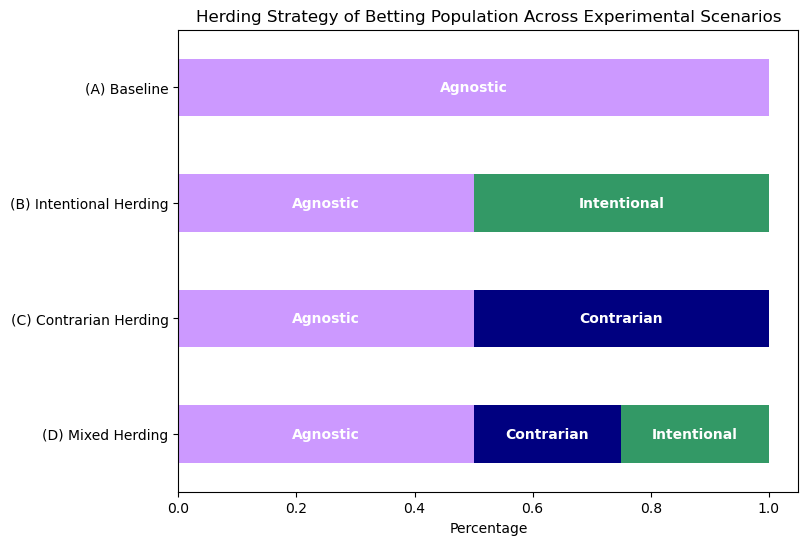

In [ ]:
# Scenario for Herding Tests
colors = [
    "#CC99FF",  # lavender purple (existing)
    "#000080",  # navy blue (existing)
    "#339966",  # forest green (existing)
    "#F4A261",  # muted orange
    "#B22222",  # deep ruby red
    "#6A4C93",  # royal violet
    "#1D3557",  # dark indigo
    "#2A9D8F",  # teal
    "#457B9D",   # steel blue,
    "#FFB347",  # warm amber/orange
    "#E63946"  # deep crimson red
]

data = {
    'Scenario': ['(A) Baseline', '(B) Intentional Herding' , '(C) Contrarian Herding', '(D) Mixed Herding'],
    'Agnostic': [1, 0.5, 0.5, 0.5],
    'Contrarian': [0, 0, 0.5, 0.25],
    'Intentional': [0, 0.5, 0, 0.25]
}
df = pd.DataFrame(data)

# Ensure Scenario is ordered as provided
df['Scenario'] = pd.Categorical(df['Scenario'], categories=data['Scenario'], ordered=True)
df = df.set_index('Scenario')

# Horizontal stacked bar plot
ax = df.plot(kind='barh', stacked=True, figsize=(8, 6), color = colors)
# Loop through the bars and add labels
for container in ax.containers:
    # Each container holds all the rectangles for one category
    for rect in container:
        width = rect.get_width()
        if width > 0.05:  # Only label if it's not too small
            x = rect.get_x() + width / 2
            y = rect.get_y() + rect.get_height() / 2
            ax.text(x, y,
                    f"{container.get_label()}",   # use the category name
                    ha='center', va='center',
                    fontsize=10, color='white', fontweight='bold')

# Remove the legend since labels are inside bars
ax.legend_.remove()

plt.title('Herding Strategy of Betting Population Across Experimental Scenarios')
plt.xlabel('Percentage')
plt.ylabel('')
#plt.legend(title='Shares')
plt.gca().invert_yaxis()

plt.savefig('../../plots/herding_experimental_setup.png', bbox_inches='tight',   # ensures all labels/axes are included
            dpi=300)
plt.show()

### Market Valuation Update Process by Stubbornness

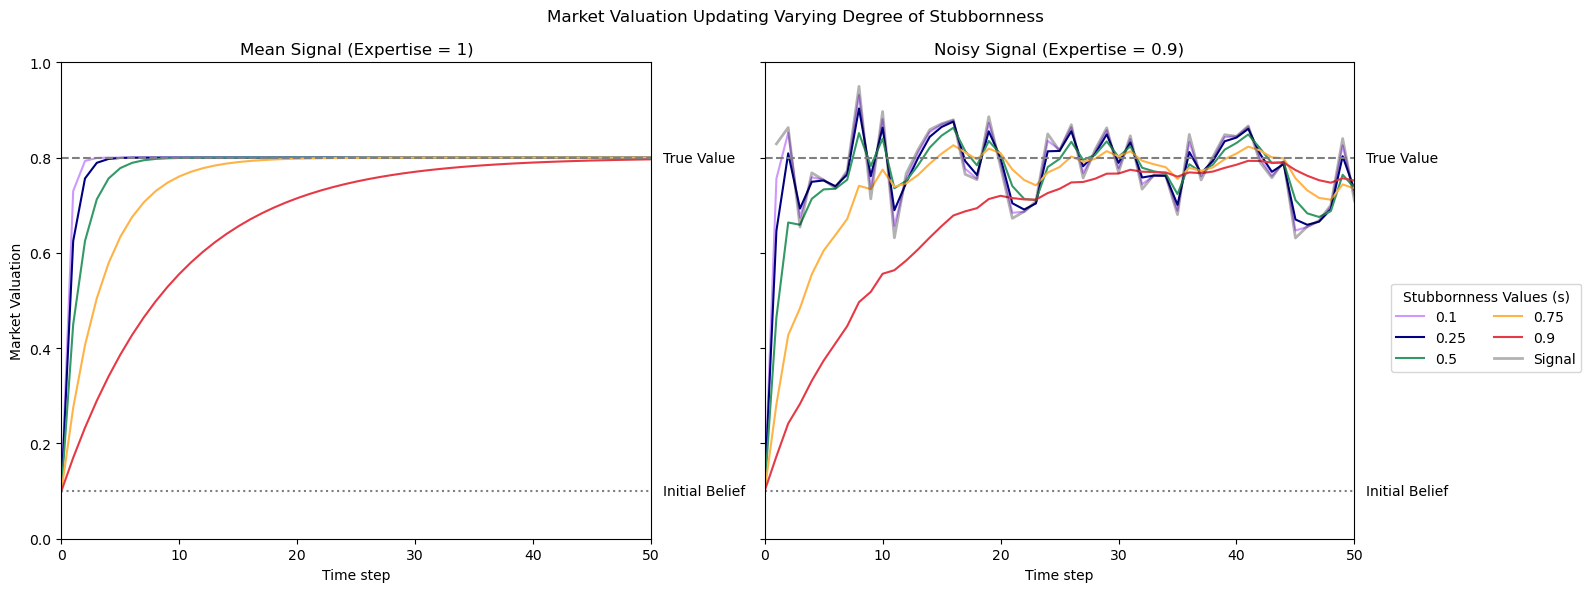

In [220]:
# --- settings ---
n_steps       = 50
belief0       = 0.1         # initial belief
true_value    = 0.8         # ground truth
bias_val      = 0.0          # subtractive bias (set to 0 if unused)
expertise_val = 1          # higher = less noisy signals
s_vals        = [0.1, 0.25, 0.5, 0.75, 0.9]

rng = np.random.default_rng(42)  # reproducible randomness (optional)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for idx, e in enumerate([1, 0.9]):
    ax = axes[idx]

    # --- one common signal path for all agents ---
    sigma   = max(1e-9, 1 - e)          # std dev; guard against 0
    signals = rng.normal(loc=true_value, scale=sigma, size=n_steps)

    # --- simulate updates for each s using the SAME signals ---
    update_dict = {}
    for s in s_vals:
        vals = [belief0]
        for k in range(n_steps):
            new_val = (1 - s) * (signals[k] - bias_val) + s * vals[-1]
            vals.append(np.clip(new_val, 0, 1))      # keep in [0,1]
        update_dict[s] = vals

    # --- plot each trajectory ---
    for i, (s, v_list) in enumerate(update_dict.items()):
        ax.plot(range(len(v_list)), v_list, label=f"{s}", color = colors[i])

    if e != 1:
        ax.plot(range(1, n_steps + 1), np.clip(signals, 0, 1),
                color="k", alpha=0.3, linewidth=2, label="Signal")

    # reference lines
    ax.axhline(y=true_value,  color="tab:gray", linestyle="--")
    ax.axhline(y=belief0,     color="tab:gray", linestyle=":")
    ax.text(n_steps + 1, true_value, "True Value", va="center", ha="left", color="black")
    ax.text(n_steps + 1, belief0, "Initial Belief", va="center", ha="left", color="black")

    ax.set_xlim(0, n_steps)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time step")
    if idx == 0:
        ax.set_ylabel("Market Valuation")
    if e == 1:
        ax.set_title("Mean Signal (Expertise = 1)")
    else:
        ax.set_title("Noisy Signal (Expertise = 0.9)")

# Place legend once for both subplots
axes[1].legend(ncol=2, title="Stubbornness Values (s)", bbox_to_anchor=(1.05, 0.55), loc="upper left")
plt.suptitle("Market Valuation Updating Varying Degree of Stubbornness")
plt.tight_layout()
plt.savefig('../../plots/stylised_p_stubbornness.png', bbox_inches='tight',   # ensures all labels/axes are included
            dpi=300)
plt.show()



### Election Outcome Signal by Expertise and Bias

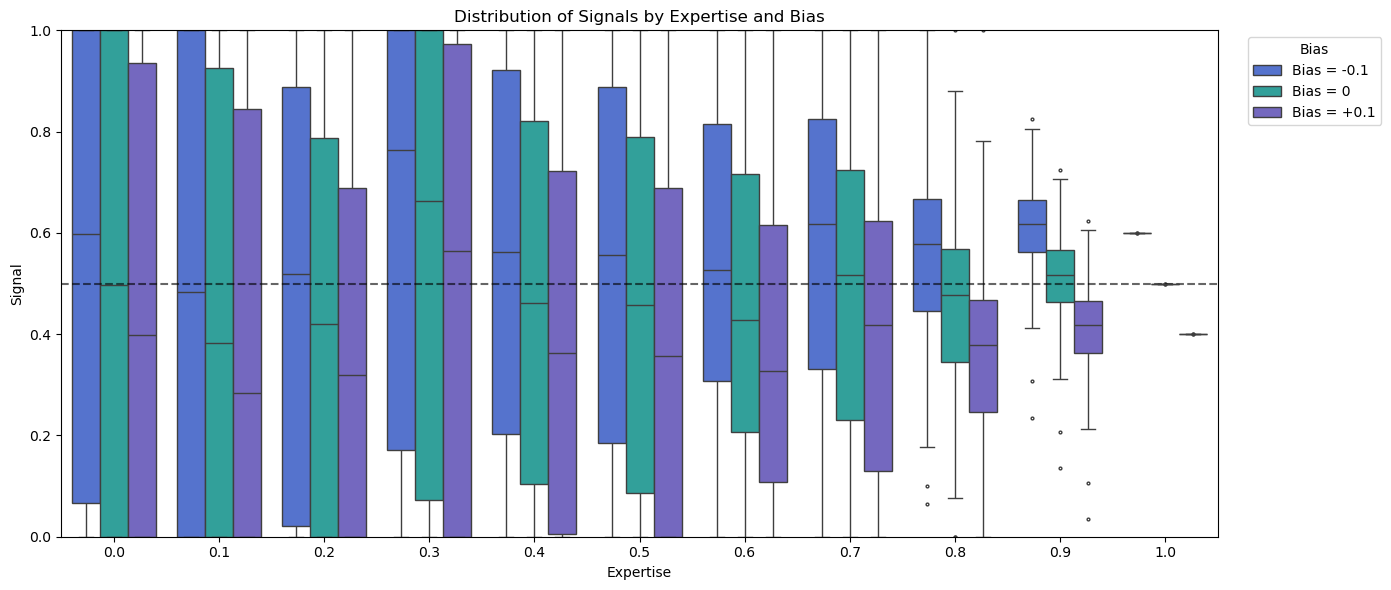

In [308]:

true_value = 0.5
e_vals     = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bias_levels = [-0.1, 0.0, 0.1]        # three biases per expertise
n_samples  = 100
rng = np.random.default_rng(42)       # reproducible

# --- generate data: same number of samples for each (expertise, bias) ---
rows = []
for e in e_vals:
    sigma = max(1e-9, 1 - e)  # avoid zero std at e=1
    base  = rng.normal(loc=true_value, scale=sigma, size=n_samples)
    for b in bias_levels:
        samples = np.clip(base - b, 0, 1)  # apply bias and clip to [0,1]
        rows.extend({"Expertise": e, "Bias": b, "Signal": s} for s in samples)

df = pd.DataFrame(rows)

# Make Expertise categorical to control order & nice x tick labels
df["Expertise"] = pd.Categorical(df["Expertise"], categories=e_vals, ordered=True)
df["Bias"] = df["Bias"].map({-0.1: "Bias = -0.1", 0.0: "Bias = 0", 0.1: "Bias = +0.1"})


# --- BOX PLOT (alternative) ---
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df, x="Expertise", y="Signal", hue="Bias",
    dodge=True, fliersize=2,
    palette=["#4169E1", "#20B2AA", "#6A5ACD"]
)
plt.axhline(true_value, ls="--", color="k", alpha=0.6)
plt.ylim(0, 1)
plt.xlabel("Expertise")
plt.ylabel("Signal")
plt.title("Distribution of Signals by Expertise and Bias")
plt.legend(title="Bias", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig('../../plots/stylised_e_bias_signals.png', bbox_inches='tight',   # ensures all labels/axes are included
            dpi=300)
plt.show()


### Utility, Expected Utility, and Trade Decision

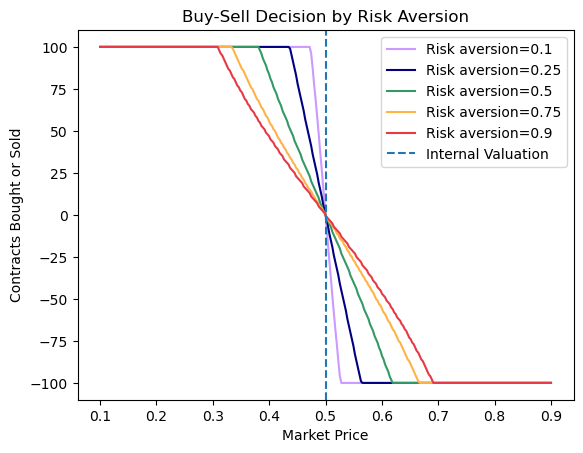

In [315]:
def exp_utility(mkt_price, new_c, budget, n_contracts, market_valuation, risk_av):
        ''' 
        Expected utility function that takes into account the market price, budget, and market valuation of a better to determine the value of any trade (new_c)
        mkt_price: current market price
        new_c: possible number of contracts to trade: negative (positive) new_c = sell (buy)
        Return: Expected utility of a particular trade volume offered to sell or buy
        '''

        return market_valuation * utility(budget - mkt_price*new_c + n_contracts + new_c, risk_av) + ((1-market_valuation)*utility(budget - mkt_price*new_c, risk_av))
    
def utility(w, risk_av):
        ''' 
        Function defining utility of wealth according to risk aversion factor
        W: wealth 
        Return: risk-adjusted value of wealth
        '''
        if risk_av ==1:
            return np.log(w)
        else:
            return (w**(1-risk_av))/(1-risk_av)

def trade(mkt_price, budget, n_contracts, new_c, market_valuation, risk_av):
    ''' 
    Function maximising the expected utility above to decide how many contracts to buy or sell constrained by budget
    Return: The number of contracts offerd to either sell (negative) or buy (positive)
    '''
    c_range = np.arange((-1*(int(budget) + n_contracts)), int(budget)+1)
    offered_contracts = c_range[np.argmax([exp_utility(mkt_price, x, budget, n_contracts, market_valuation, risk_av) for x in c_range])]
    return offered_contracts

exp_utility(0.5, 5, 100, 3, 0.7, 0.5)

trade(0.5, # Market Price
      100, # Budget
      3, # Number of contracts currently held
      3, # New contracts
      0.7, # Market valuation
      0.2) # Risk aversion

internal_val = 0.5
risk_av = [0.1, 0.25, 0.5, 0.75, 0.9]
m_prices = np.linspace(0.1, 0.9, 300)  # 200 evenly spaced points

for i, r in enumerate(risk_av):
    k_list = []
    for m in m_prices:
        k = trade(m, 100, 0, 0, internal_val, r)
        k_list.append(k)

    plt.plot(m_prices, k_list, label=f"Risk aversion={r}", color = colors[i])

plt.axvline(x=internal_val, linestyle="dashed", label="Internal Valuation")

plt.xlabel("Market Price")
plt.ylabel("Contracts Bought or Sold")
plt.title("Buy-Sell Decision by Risk Aversion")
plt.legend()
plt.savefig('../../plots/stylised_risk_av_buy_sell.png', bbox_inches='tight', dpi=300)
plt.show()

